In [1]:
# %pip install kshape

  Created wheel for kshape: filename=kshape-1.0.1-py3-none-any.whl size=4613 sha256=fb7b760ac6a46b37ae0fd17810e6a23e4a4843db00c30addc93fc739601a4276
  Stored in directory: c:\users\benja\appdata\local\pip\cache\wheels\88\84\cc\683740a3917f48d0dab1e744f217be9403082bbb619c5d7e42
Successfully built kshape
Note: you may need to restart the kernel to use updated packages.


In [58]:
from common_imports import *
from kshape.core import kshape, zscore
import regex as re
from IPython.display import display, Markdown

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
stop_english = stopwords.words('english')
stop_english.extend(('say', 'says', 'saying', 'said', 'new', 'would', 'want', 'wanted', 'wants', 'wanting', 'still', 'must', 'also', 'time', 'year', 'however', 'first', 'university', 'research', 'analysis', 'study', 'journal', 'press', 'number', 'group', 'groups', 'among', 'sociology', 'table', 'different', 'less', 'that', 'one', 'may', 'two', 'percent', 'use', 'within', 'york', 'see', 'thus', 'high', 'level', 'well', 'three', 'data'))

In [46]:
# cc = counter('count-cooc-2pct-250')
cc = counter('count2-pruned')

Loading count2-pruned from disk...


In [47]:
len(cc.items('t'))

14297

In [48]:
terms = cc.items('t')

def flatten(t):
    return [item for sublist in t for item in sublist]

terms_processed = [word.split("-") for word in terms]
terms_processed = flatten(terms_processed)

terms_processes = [re.findall("[A-Za-z]+", word) for word in terms_processed]
terms_processed = [SnowballStemmer("english").stem(word) for word in terms_processed]
terms_processed = [item for item in terms_processed if len(item)>2]
terms_processed = [item for item in terms_processed if item not in stop_english]

res = []
[res.append(x) for x in terms_processed if x not in res]

print(len(res))

top_terms = sorted(res, key=lambda x:-cc(t=x))[:10]
print(top_terms)

4247
['social', 'women', 'work', 'american', 'model', 'life', 'state', 'class', 'health', 'men']


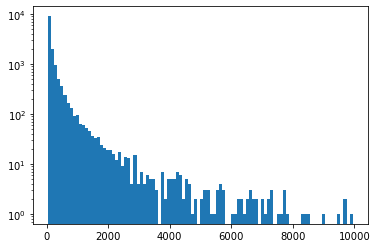

In [49]:
tc = cc.counts[('t',)]
plt.hist(tc[tc<10000], bins=100, log=True);

### cluster the top 10% using KShape

In [52]:
cutoffq = 0.90
cutoff = np.quantile( cc.counts[('t',)], cutoffq )
print(f"Setting {cutoffq:0.1%} percentile at {cutoff:0,.0f} total citations.")

Setting 90.0% percentile at 536 total citations.


In [53]:
ts_to_cluster = [t for t in cc.items('t') if cc(t=t) > cutoff and t in res]
print(f"{len(ts_to_cluster)} time series total.")

419 time series total.


In [54]:
time_series = [ [cc(t=t, fy=Y) for Y in range(1970, 2015)] for t in ts_to_cluster ]

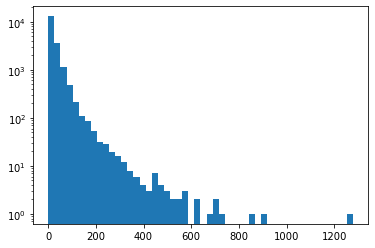

In [55]:
plt.hist( [y for x in time_series for y in x], bins=50, log=True );

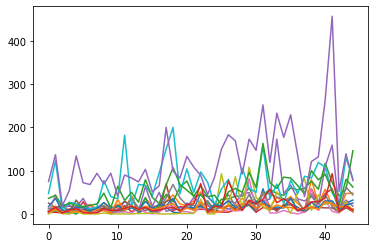

In [56]:
for ts in time_series[:15]:
    plt.plot(ts);

In [104]:
np.array(time_series).shape

(1428, 45)

In [62]:
cluster_num = 10
clusters = kshape(zscore(time_series, axis=1), cluster_num)

In [59]:
len(clusters)

5

In [60]:
[len(x[1]) for x in clusters]

[3, 6, 6, 3, 7]

# Cluster 0

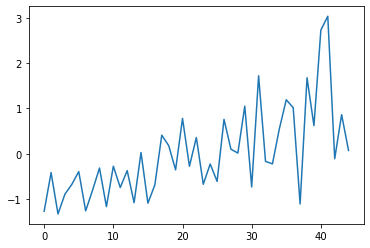

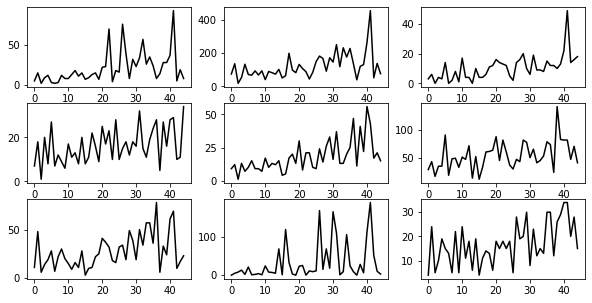

# Cluster 1

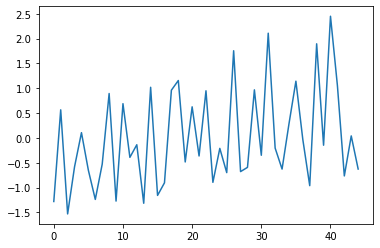

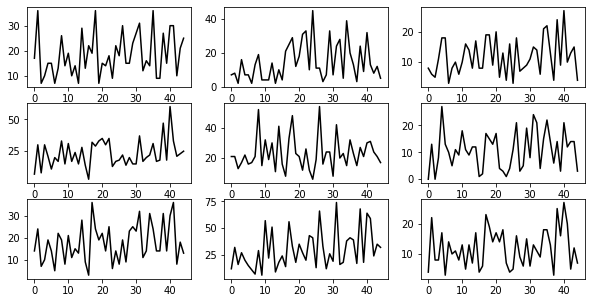

# Cluster 2

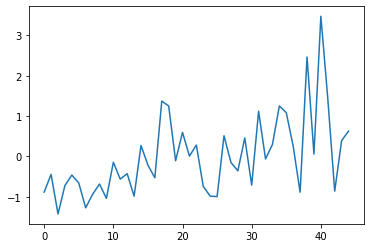

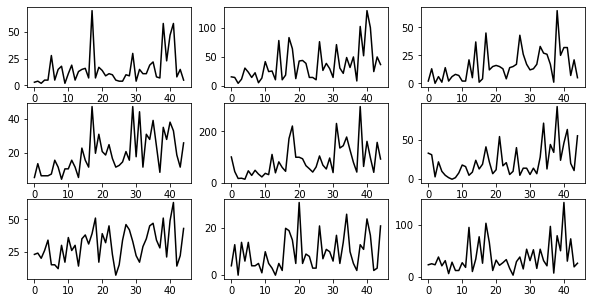

# Cluster 3

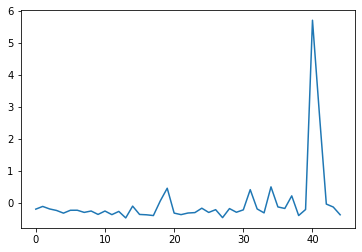

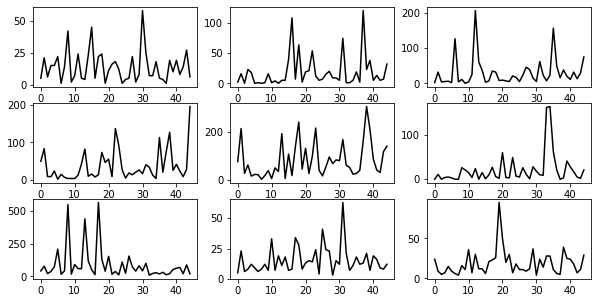

# Cluster 4

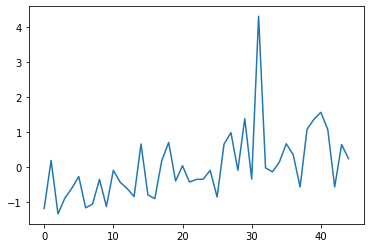

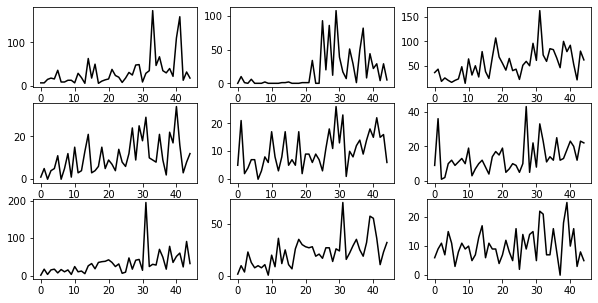

# Cluster 5

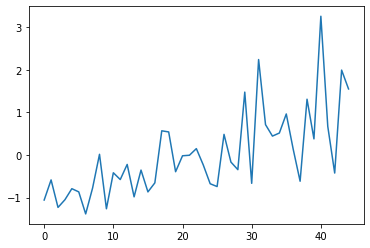

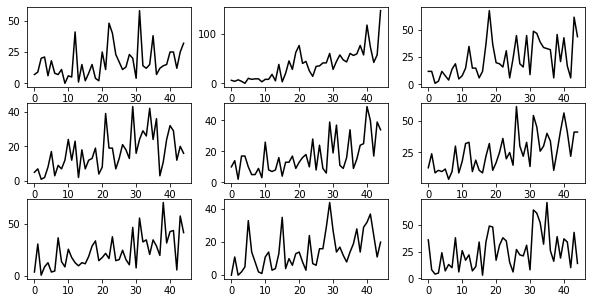

# Cluster 6

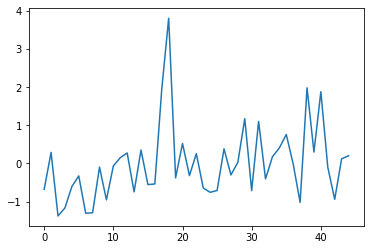

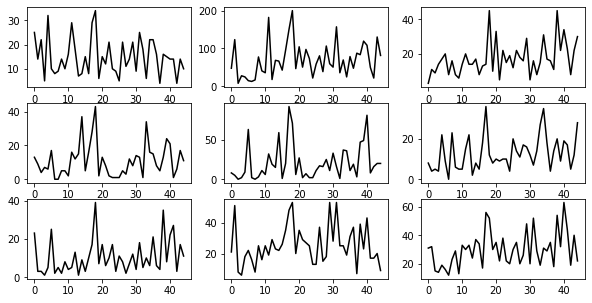

# Cluster 7

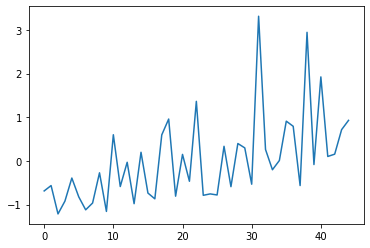

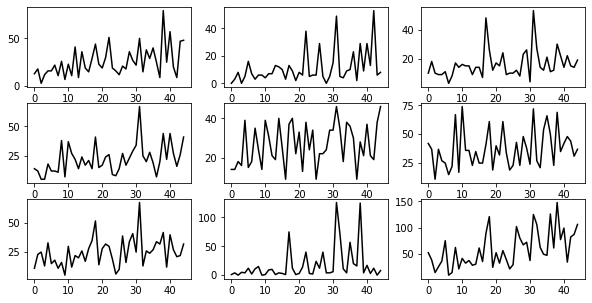

# Cluster 8

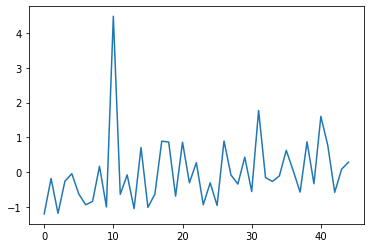

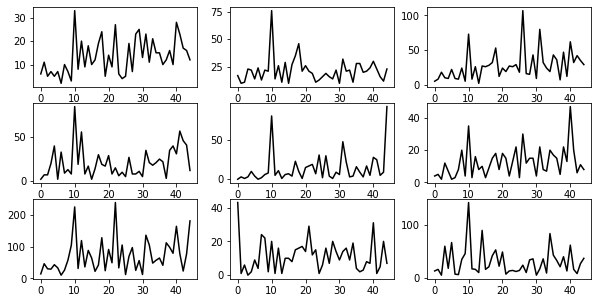

# Cluster 9

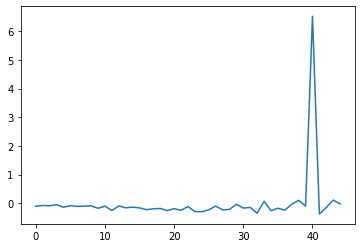

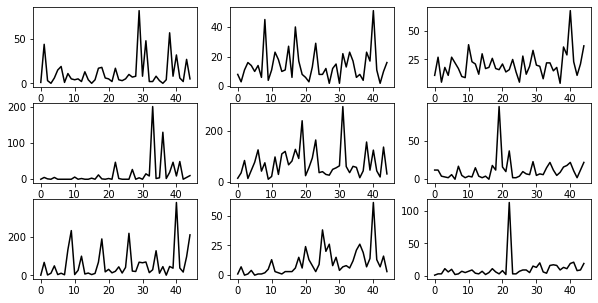

In [74]:
for ci in range(len(clusters)):
    display(Markdown(f"# Cluster {ci}"))
    
    c = clusters[ci]

    plt.plot(c[0]); # reference. mean.
    plt.show()

    plt.figure(figsize=(10,5)) # examples.
    for ti,ts in enumerate(c[1][:9]):
        plt.subplot(3,3,ti+1)
        plt.plot(time_series[ts], color='black')
        
    plt.show()

### let's try smoothing or windowing, and taking percentages

In [89]:
cutoffq = 0.8
cutoff = np.quantile( cc.counts[('t',)], cutoffq )
print(f"Setting {cutoffq:0.1%} percentile at {cutoff:0,.0f} total citations.")

Setting 80.0% percentile at 282 total citations.


In [90]:
ts_to_cluster = [t for t in cc.items('t') if cc(t=t) > cutoff and t in res]
print(f"{len(ts_to_cluster)} time series total.")

720 time series total.


In [91]:
time_series = np.array([ [cc(t=t, fy=Y) for Y in range(1970, 2015)] for t in ts_to_cluster ])
year_totals = np.sum(time_series, axis=0)

In [94]:
time_seriesp = time_series / year_totals[np.newaxis,:]

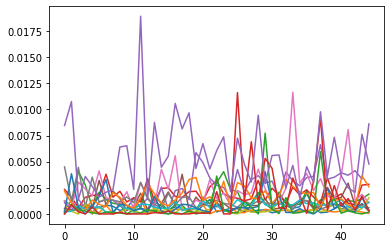

In [95]:
for ts in time_seriesp[:15]:
    plt.plot(ts);

In [96]:
window_size = 5
time_seriespw = np.array([ [
    sum( cc(t=t, fy=Y) for Y in range(YS, YS+window_size) ) / np.sum( year_totals[YS-1970:YS-1970+window_size] )
    for YS in range(1970, 2010+window_size, window_size)
] for t in ts_to_cluster ])

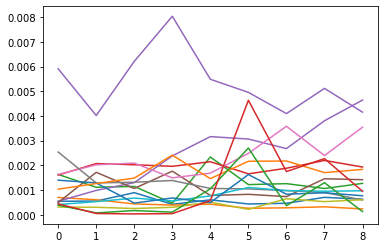

In [97]:
for ts in time_seriespw[:15]:
    plt.plot(ts);

In [103]:
cluster_num = 8
#ps_int = np.array(time_seriespw*1e4, dtype=np.int64)
zs = zscore(time_seriespw, axis=1)

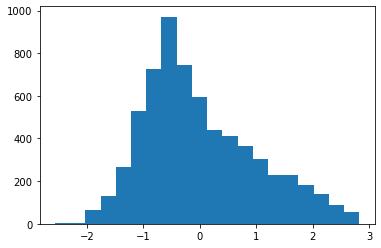

In [104]:
plt.hist(zs.flatten(), bins=20);
plt.show()
#plt.hist(ps_int, bins=100);
#plt.show()

In [105]:
clusters = kshape(zs, cluster_num)

In [85]:
print([len(x[1]) for x in clusters])

[22, 51, 53, 56, 35, 37, 33, 66, 28, 38]


# Cluster 0

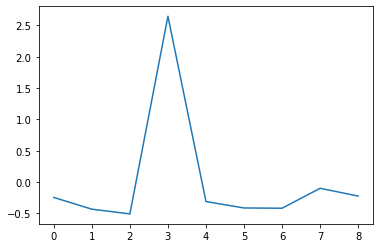

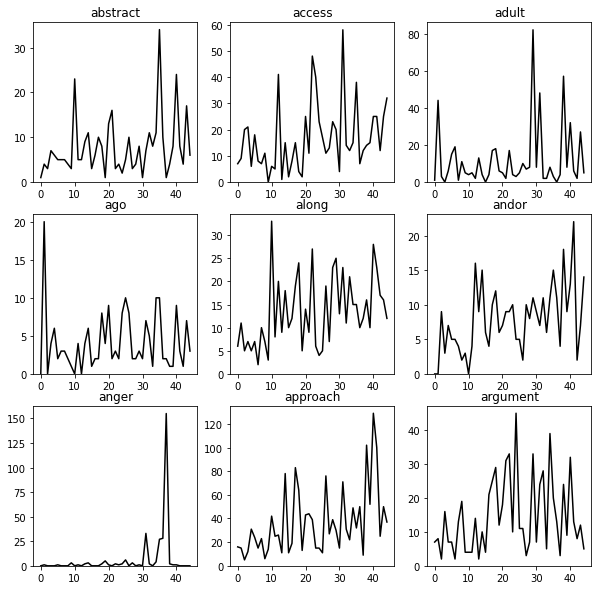

# Cluster 1

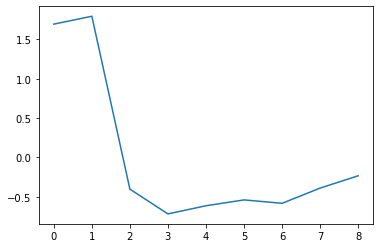

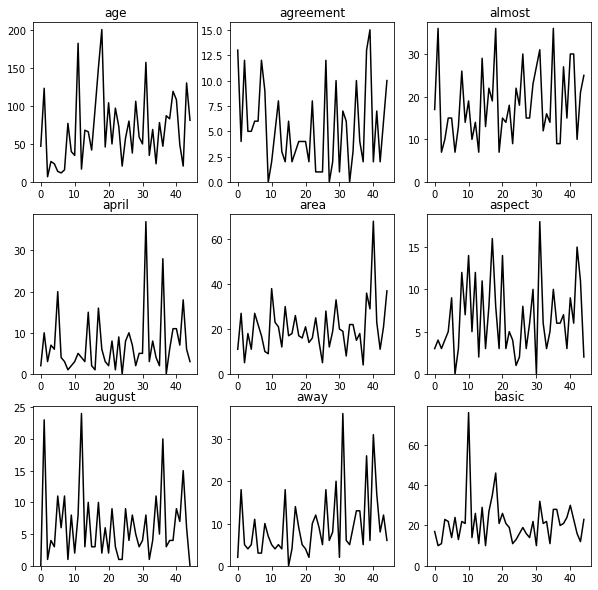

# Cluster 2

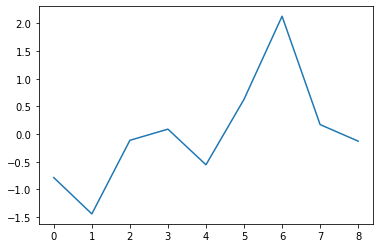

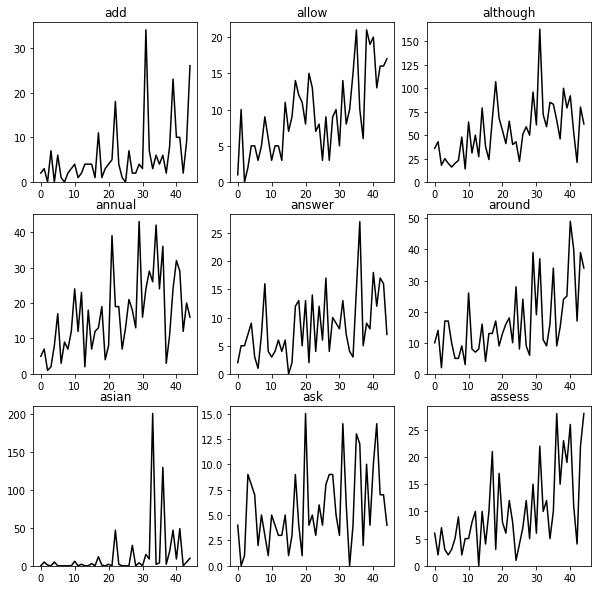

# Cluster 3

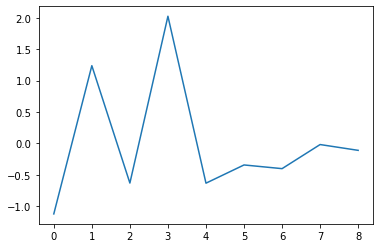

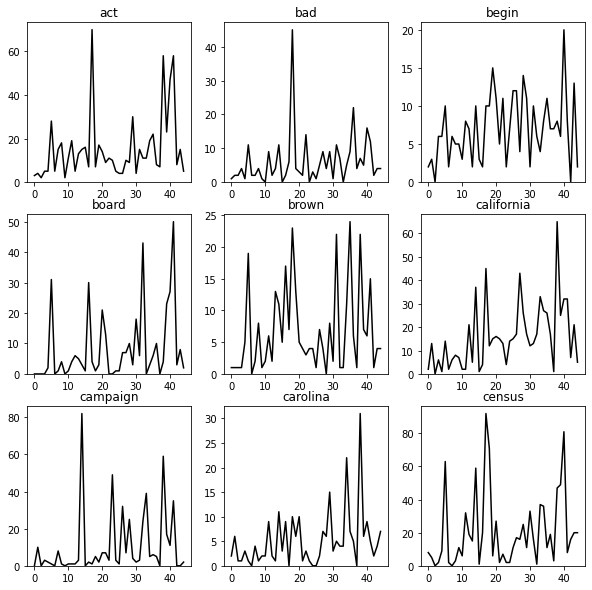

# Cluster 4

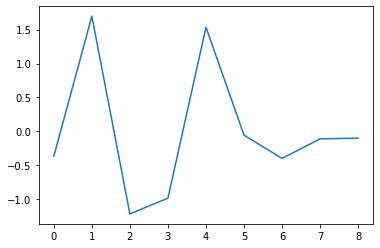

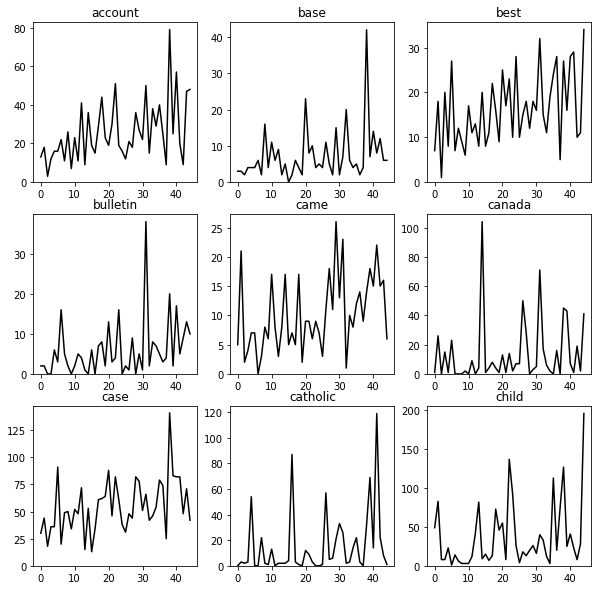

# Cluster 5

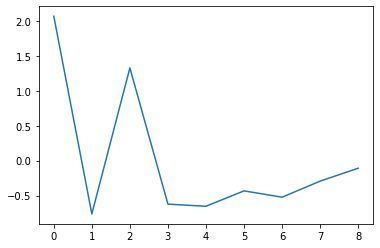

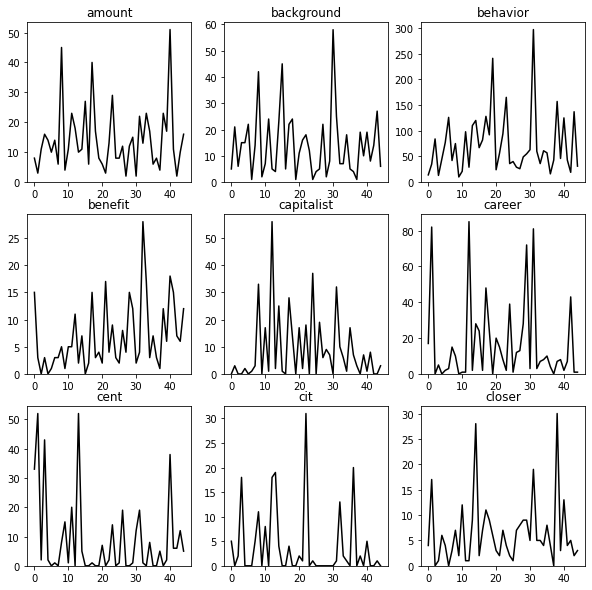

# Cluster 6

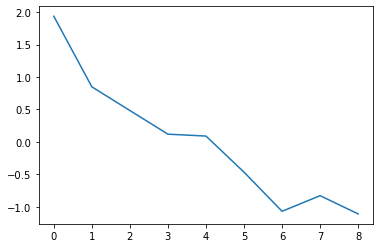

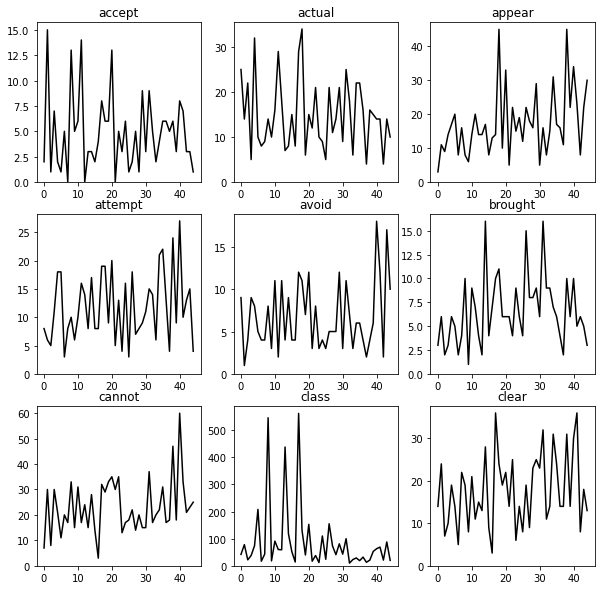

# Cluster 7

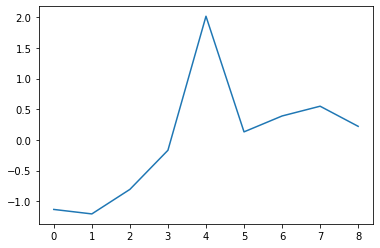

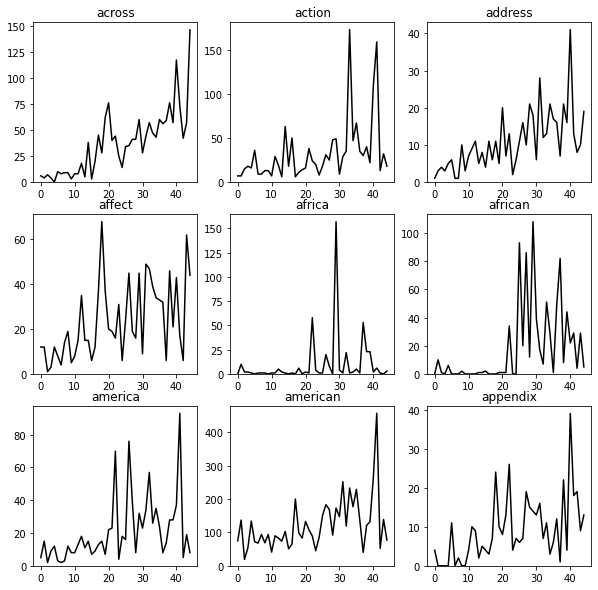

In [106]:
for ci in range(len(clusters)):
    display(Markdown(f"# Cluster {ci}"))
    
    c = clusters[ci]

    plt.plot(c[0]); # reference. mean.
    plt.show()

    plt.figure(figsize=(10,10)) # examples.
    for ti,ts in enumerate(c[1][:9]):
        plt.subplot(3,3,ti+1)
        plt.plot(time_series[ts], color='black')
        plt.title(ts_to_cluster[ts])
        plt.ylim(0,None)
        
    plt.show()